# Long-Short Strategy, Part 1: Preparing Alpha Factors and Features

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. `preparing_the_model_data` (this noteboook): we'll engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [1]:
import time
import warnings

from tqdm import tqdm

from data.data_loader import data_loader
from utils import reduce_footprint

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
#START = '2010-01-01'
#END = '2021-05-01'

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]



## Loading Crypto Prices & Meta Data


In [7]:
suffix = '5Min_ncut_1obsy_lbackmany'
print(f"suffix: {suffix}")
downsampleshift = False
minutes_per_base_frequency = 5
factor_scaling = 1 # 5 minute frequency but everything
T = [1, 2, 3, 4, 5, 6, 12, 24, 48]

prices, metadata, categories = data_loader(timeframe='5Min',
                                           minutes_per_base_frequency=minutes_per_base_frequency,  # 5 Minutes sampled input data in data path
                prices_path='../data/crypto/prices_5Min.ftr',
                min_observation_years=1,
                drop_level=True,
                exclude_stablecoins=True,
                cut=False,
                n_min_tickers=0,
                reduce_size=True,
                downsampleshift=downsampleshift,
                d_shift=60,
                join_sector=False,
                join_sectors=False)

print('prices dates {}:{}'.format(prices.index.get_level_values('date').min(),
                                 prices.index.get_level_values('date').max()))

suffix: 5Min_ncut_1obsy_lbackmany

reducing footprint

prices dates 2013-04-01 00:10:00:2021-06-23 14:35:00


In [8]:
if downsampleshift:
    glevel= ['ticker', 'offset'] # no downsampleshift
else:
    glevel= ['ticker'] # no downsampleshift



<AxesSubplot:xlabel='date'>

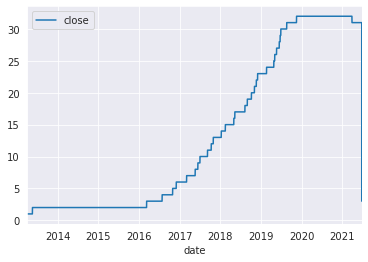

In [9]:
cols=['close']
prices[cols].groupby('date').count().plot()

In [10]:
prices.unstack(glevel).head()


open                                          \
ticker                 btc-usd ltc-usd eth-usd etc-usd zec-usd xmr-usd   
date                                                                     
2013-04-01 00:10:00  93.250000     NaN     NaN     NaN     NaN     NaN   
2013-04-01 00:15:00  93.349998     NaN     NaN     NaN     NaN     NaN   
2013-04-01 00:20:00  93.349998     NaN     NaN     NaN     NaN     NaN   
2013-04-01 00:25:00  93.349998     NaN     NaN     NaN     NaN     NaN   
2013-04-01 00:30:00  93.043991     NaN     NaN     NaN     NaN     NaN   

                                                        ...  volume          \
ticker              dash-usd xrp-usd miota-usd eos-usd  ... bsv-usd btt-usd   
date                                                    ...                   
2013-04-01 00:10:00      NaN     NaN       NaN     NaN  ...     NaN     NaN   
2013-04-01 00:15:00      NaN     NaN       NaN     NaN  ...     NaN     NaN   
2013-04-01 00:20:00      NaN     NaN       NaN     NaN  ...     NaN     NaN   
2013-04-01 00:25:00      NaN     NaN       NaN     NaN  ...     NaN     NaN   
2013-04-01 00:30:00      NaN     NaN       NaN     NaN  ...     NaN     NaN   

                                                                        \
ticker              atom-usd wbtc-usd leo-usd okb-usd algo-usd amp-usd   
date                                                                     
2013-04-01 00:10:00      NaN      NaN     NaN     NaN      NaN     NaN   
2013-04-01 00:15:00      NaN      NaN     NaN     NaN      NaN     NaN   
2013-04-01 00:20:00      NaN      NaN     NaN     NaN      NaN     NaN   
2013-04-01 00:25:00      NaN      NaN     NaN     NaN      NaN     NaN   
2013-04-01 00:30:00      NaN      NaN     NaN     NaN      NaN     NaN   

                                     
ticker              ftt-usd chz-usd  
date                                 
2013-04-01 00:10:00     NaN     NaN  
2013-04-01 00:15:00     NaN     NaN  
2013-04-01 00:20:00     NaN     NaN  
2013-04-01 00:25:00     NaN     NaN  
2013-04-01 00:30:00     NaN     NaN  

[5 rows x 160 columns]

In [11]:
print('unique tickers {} \n{}'.format(prices.index.get_level_values('ticker').nunique(),
                                 prices.index.get_level_values('ticker').unique()))

unique tickers 32 
CategoricalIndex(['btc-usd', 'ltc-usd', 'eth-usd', 'etc-usd', 'zec-usd',
                  'xmr-usd', 'dash-usd', 'xrp-usd', 'miota-usd', 'eos-usd',
                  'neo-usd', 'qtum-usd', 'btg-usd', 'bat-usd', 'trx-usd',
                  'xlm-usd', 'mkr-usd', 'bnt-usd', 'vet-usd', 'xtz-usd',
                  'dgb-usd', 'enj-usd', 'bsv-usd', 'btt-usd', 'atom-usd',
                  'wbtc-usd', 'leo-usd', 'okb-usd', 'algo-usd', 'amp-usd',
                  'ftt-usd', 'chz-usd'],
                 categories=['btc-usd', 'ltc-usd', 'eth-usd', 'etc-usd', 'zec-usd', 'xmr-usd', 'dash-usd', 'xrp-usd', ...], ordered=False, name='ticker', dtype='category')


In [12]:
prices.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11626940 entries, (Timestamp('2013-04-01 00:10:00', freq='5T'), 'btc-usd') to (Timestamp('2021-06-23 14:35:00', freq='5T'), 'chz-usd')
Data columns (total 5 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    11626940 non-null  float32
 1   high    11626940 non-null  float32
 2   low     11626940 non-null  float32
 3   close   11626940 non-null  float32
 4   volume  11626940 non-null  float64
dtypes: float32(4), float64(1)
memory usage: 360.4 MB


## Add some Basic Factors

See [appendix](../24_alpha_factor_library) for details on the below indicators.

### Compute the Relative Strength Index

<AxesSubplot:xlabel='date'>

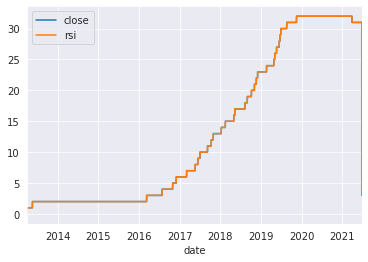

In [13]:
"""
def compute_rsi(close):
    rsi = RSI(close, timeperiod=20*factor_scaling)
    return pd.DataFrame({'rsi': rsi,}, index=close.index)

prices = (prices.join(prices
                      .groupby(glevel)
                      .close
                      .apply(compute_rsi)))
"""
prices['rsi'] = prices.groupby(glevel).close.apply(lambda c: RSI(c, timeperiod=14*factor_scaling))


cols=['close', 'rsi']
prices[cols].groupby('date').count().plot()

In [14]:
prices['rsi'].dropna()

date                 ticker  
2013-04-01 01:20:00  btc-usd     63.658192
2013-04-01 01:25:00  btc-usd     63.874979
2013-04-01 01:30:00  btc-usd     57.237839
2013-04-01 01:35:00  btc-usd     57.237839
2013-04-01 01:40:00  btc-usd     40.114639
                                   ...    
2021-06-23 14:30:00  amp-usd     54.602495
                     chz-usd     24.144709
2021-06-23 14:35:00  leo-usd     46.204308
                     algo-usd    54.800355
                     chz-usd     39.058654
Name: rsi, Length: 11626492, dtype: float64

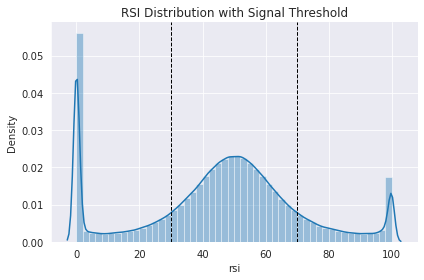

In [15]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

### Compute Bollinger Bands

In [16]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20*factor_scaling)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [17]:
prices = (prices.join(prices
                      .groupby(glevel)
                      .close
                      .apply(compute_bb)))


In [18]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

In [19]:
prices['bb_low'].unstack(glevel).dropna().head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2019-11-15 12:55:00,0.002670,0.006136,0.004053,0.001931,0.008728,0.006059,0.006020,0.006876,0.004131,0.002821,...,0.006890,0.000000,0.015319,4.724737e-08,0.001078,0.0,0.000000,0.017545,0.0,0.676285
2019-11-15 13:00:00,0.003997,0.007770,0.004295,0.001949,0.010092,0.007399,0.005936,0.007261,0.004114,0.003279,...,0.008774,0.000000,0.014633,4.724737e-08,0.000591,0.0,0.000000,0.017742,0.0,0.623835
2019-11-15 13:05:00,0.005626,0.008088,0.004459,0.003648,0.009679,0.008269,0.009239,0.006818,0.006335,0.004728,...,0.009393,0.000000,0.013834,4.724737e-08,0.000293,0.0,0.000000,0.012137,0.0,0.558706
2019-11-15 13:10:00,0.007279,0.007964,0.006555,0.005598,0.012141,0.009032,0.009334,0.006797,0.006926,0.003239,...,0.009547,0.000000,0.012912,4.724737e-08,0.000665,0.0,0.000000,0.015654,0.0,0.473902
2019-11-15 13:25:00,0.006338,0.007377,0.004301,0.001803,0.012026,0.007401,0.007951,0.006964,0.007692,0.001428,...,0.010257,0.000000,0.009189,4.724737e-08,0.001123,0.0,0.000000,0.006909,0.0,-0.888467
2019-11-15 13:30:00,0.005451,0.006225,0.004248,0.001803,0.012060,0.006845,0.006989,0.004229,0.007737,0.002007,...,0.007885,0.000000,0.007450,4.724737e-08,-0.000091,0.0,0.000000,0.005305,0.0,0.000000
2019-11-15 13:35:00,0.005036,0.003806,0.003993,0.001855,0.011280,0.006829,0.006513,0.002177,0.007773,0.001918,...,0.007528,0.000000,0.005177,4.724737e-08,-0.000393,0.0,0.000000,0.009933,0.0,0.407315
2019-11-15 13:40:00,0.004756,0.002857,0.002958,0.001106,0.007275,0.006811,0.005418,0.002293,0.006288,0.001942,...,0.006451,0.000000,0.000000,4.724737e-08,-0.000188,0.0,0.000000,0.008861,0.0,0.661776
2019-11-15 13:45:00,0.004271,0.004043,0.001763,0.001131,0.006248,0.006273,0.004783,0.001960,0.005720,0.001576,...,0.006040,0.000000,0.000000,4.724737e-08,-0.000069,0.0,0.000000,0.005117,0.0,0.840303


In [20]:
prices['bb_high'].unstack(glevel).dropna().head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2019-11-15 12:55:00,0.001552,0.001741,0.000429,0.003923,0.001924,0.004106,0.000927,0.000351,0.002133,0.001936,...,0.001025,0.000000,0.005772,4.724737e-08,0.002238,0.0,0.000000,0.008317,0.0,0.298553
2019-11-15 13:00:00,0.000314,0.000144,0.000476,0.003632,0.001094,0.001799,0.001232,0.000531,0.002210,0.001467,...,0.000068,0.000000,0.006137,4.724737e-08,0.002649,0.0,0.000000,0.008087,0.0,0.294124
2019-11-15 13:05:00,-0.000505,0.000547,0.000625,0.001616,0.001913,0.000840,-0.000858,0.001367,0.000515,0.000382,...,0.000366,0.000000,0.006390,4.724737e-08,0.003050,0.0,0.000000,0.012363,0.0,0.283842
2019-11-15 13:10:00,-0.000940,0.001132,-0.000580,0.000095,0.000464,0.000598,-0.000065,0.001699,0.000486,0.001893,...,0.000976,0.000000,0.006522,4.724737e-08,0.002696,0.0,0.000000,0.007488,0.0,0.264040
2019-11-15 13:15:00,0.000223,0.001403,0.000745,0.001961,0.001131,0.001078,0.000591,0.001987,-0.000408,0.001947,...,0.001522,0.000000,0.006517,4.724737e-08,0.001832,0.0,0.000000,0.012846,0.0,0.624842
2019-11-15 13:20:00,0.000885,0.001924,0.002014,0.001738,0.002233,0.001409,0.001134,0.002121,-0.000080,0.003722,...,0.001010,0.000000,0.006349,4.724737e-08,0.001860,0.0,0.000000,0.011554,0.0,0.624154
2019-11-15 13:25:00,0.001410,0.002250,0.002177,0.003140,0.002778,0.003369,0.002313,0.002287,0.002122,0.003305,...,0.002310,0.000000,0.005973,4.724737e-08,0.001458,0.0,0.000000,0.010530,0.0,0.626704
2019-11-15 13:30:00,0.002392,0.003441,0.002264,0.002900,0.003281,0.003866,0.003011,0.004891,0.002314,0.002442,...,0.004735,0.000000,0.005299,4.724737e-08,0.003020,0.0,0.000000,0.010895,0.0,0.628048
2019-11-15 13:35:00,0.002636,0.005049,0.002329,0.002828,0.003522,0.003954,0.003083,0.006876,0.002525,0.002540,...,0.004838,0.000000,0.004097,4.724737e-08,0.003607,0.0,0.000000,0.006131,0.0,0.628632


<AxesSubplot:xlabel='date'>

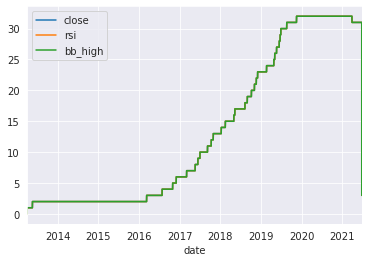

In [21]:
cols.append('bb_high')
prices[cols].groupby('date').count().plot()

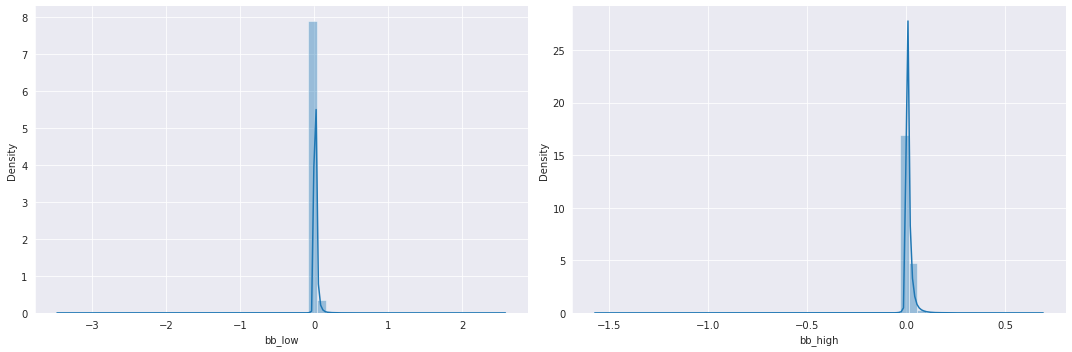

In [22]:
"""
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();
"""
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices['bb_low'].dropna(), ax=axes[0])
sns.distplot(prices['bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

### Compute Average True Range

<AxesSubplot:xlabel='date'>

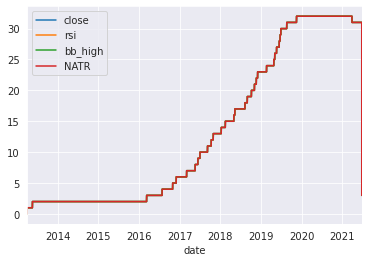

In [23]:
prices['NATR'] = prices.groupby(glevel,
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close, timeperiod=14*factor_scaling))
cols.append('NATR')
prices[cols].groupby('date').count().plot()

In [24]:
print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))

prices dates 2013-04-01 01:45:00:2021-06-23 14:35:00


In [25]:
prices['NATR'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14*factor_scaling)
    return df.sub(df.mean()).div(df.std())


In [27]:
prices['ATR'] = (prices.groupby(glevel, group_keys=False)
                 .apply(compute_atr))
prices['ATR'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


prices dates 2013-04-01 01:45:00:2021-06-23 14:35:00


<AxesSubplot:xlabel='date'>

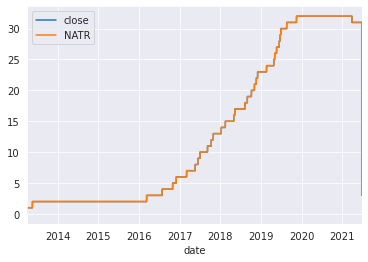

In [28]:
print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))
cols = ['close', 'NATR']
prices[cols].groupby('date').count().plot()

### Compute Moving Average Convergence/Divergence

In [29]:
prices['PPO'] = prices.groupby(glevel).close.apply(lambda c: talib.PPO(c, fastperiod=12*factor_scaling,
                                                             slowperiod= 26*factor_scaling))
prices['PPO'].unstack(glevel).head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


prices dates 2013-04-01 02:15:00:2021-06-23 14:35:00


<AxesSubplot:xlabel='date'>

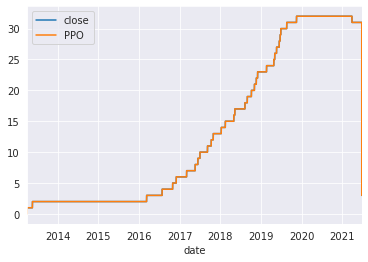

In [30]:
print('prices dates {}:{}'.format(prices.dropna().index.get_level_values('date').min(),
                                 prices.dropna().index.get_level_values('date').max()))
cols = ['close', 'PPO']
prices[cols].groupby('date').count().plot()

In [31]:
def compute_macd(close):
    macd = MACD(close, fastperiod= 12*factor_scaling,
                slowperiod= 26*factor_scaling,
                signalperiod= 9*factor_scaling)[0]
    return (macd - np.mean(macd))/np.std(macd)


In [32]:
prices['MACD'] = (prices
                  .groupby(glevel, group_keys=False)
                  .close
                  .apply(compute_macd))

In [33]:
prices['MACD']

date                 ticker  
2013-04-01 00:10:00  btc-usd          NaN
2013-04-01 00:15:00  btc-usd          NaN
2013-04-01 00:20:00  btc-usd          NaN
2013-04-01 00:25:00  btc-usd          NaN
2013-04-01 00:30:00  btc-usd          NaN
                                   ...   
2021-06-23 14:30:00  amp-usd     0.262423
                     chz-usd    -1.261897
2021-06-23 14:35:00  leo-usd    -0.681544
                     algo-usd    0.204753
                     chz-usd    -1.179511
Name: MACD, Length: 11626940, dtype: float64

<AxesSubplot:xlabel='date'>

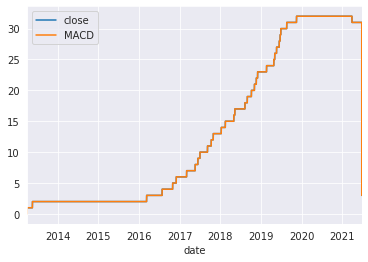

In [34]:
cols = ['close', 'MACD']
prices[cols].groupby('date').count().plot()

### Combine Price and Meta Data

In [35]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

In [36]:
prices['sector'].unstack(glevel).dropna().head(30)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2019-11-15 11:20:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 11:25:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 11:30:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 11:35:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 11:40:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 11:45:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 11:50:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 11:55:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
2019-11-15 12:00:00,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0


## Compute Returns

### Historical Returns

In [37]:
by_sym = prices.groupby(glevel).close
for t in tqdm(T):
    prices[f'r{t:02}'] = by_sym.pct_change(t)

t=int(1*factor_scaling)
prices[f'r{t:02}'].unstack(glevel).head(30)

100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:15:00,1.072407e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:20:00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:25:00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:30:00,-3.278077e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:35:00,1.676559e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:40:00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:45:00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:50:00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Daily historical return deciles

100%|██████████| 9/9 [1:27:34<00:00, 583.82s/it]


<AxesSubplot:xlabel='date'>

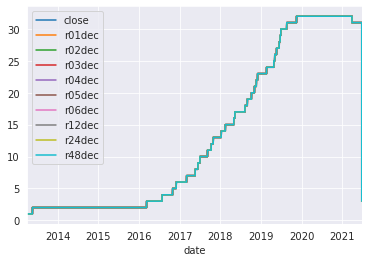

In [38]:
for t in tqdm(T):
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}']
                             .groupby('date')
                             .apply(lambda x: pd.qcut(x, 
                                                      q=3,
                                                      labels=False, 
                                                      duplicates='drop'))
                             .fillna(-1))

cols= ['close']
for t in T:
    cols.append(f'r{t:02}dec')
prices[cols].groupby('date').count().plot()

### Daily sector return deciles

100%|██████████| 9/9 [3:14:59<00:00, 1299.95s/it]  


<AxesSubplot:xlabel='date'>

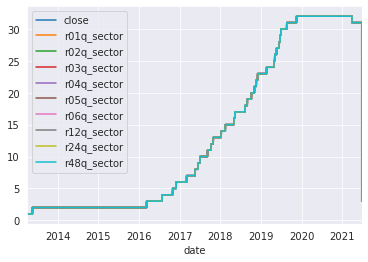

In [39]:
for t in tqdm(T):
    prices[f'r{t:02}q_sector'] = (prices
                                  .groupby(['date', 'sector'])[f'r{t:02}']
                                  .transform(lambda x: pd.qcut(x, 
                                                               q=3,
                                                               labels=False, 
                                                               duplicates='drop'))
                                  .fillna(-1))
cols= ['close']
for t in T:
    cols.append(f'r{t:02}q_sector')
prices[cols].groupby('date').count().plot()



In [40]:
"""
for t in tqdm(T):
    prices[f'r{t:02}q_sector'] = prices[f'r{t:02}q_sector'].fillna(method='ffill')#.fillna(-1)

cols = ['close', ]
for t in T:
    cols.append(f'r{t:02}q_sector')
prices[cols].groupby('date').count().plot()

prices.describe(percentiles=percentiles)
"""

"\nfor t in tqdm(T):\n    prices[f'r{t:02}q_sector'] = prices[f'r{t:02}q_sector'].fillna(method='ffill')#.fillna(-1)\n\ncols = ['close', ]\nfor t in T:\n    cols.append(f'r{t:02}q_sector')\nprices[cols].groupby('date').count().plot()\n\nprices.describe(percentiles=percentiles)\n"

<AxesSubplot:xlabel='date'>

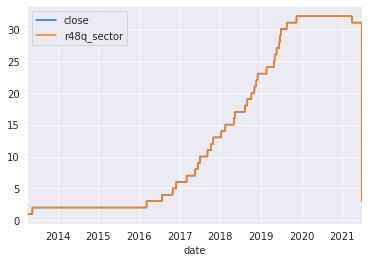

In [41]:
cols = ['close', f'r{t:02}q_sector']
prices[cols].groupby('date').count().plot()

In [42]:
prices[f'r{t:02}q_sector'].unstack(glevel)

ticker,btc-usd,ltc-usd,eth-usd,etc-usd,zec-usd,xmr-usd,dash-usd,xrp-usd,miota-usd,eos-usd,...,bsv-usd,btt-usd,atom-usd,wbtc-usd,leo-usd,okb-usd,algo-usd,amp-usd,ftt-usd,chz-usd
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01 00:10:00,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:15:00,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:20:00,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:25:00,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:30:00,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23 14:15:00,1.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,...,1.0,2.0,0.0,1.0,0.0,NaN,2.0,2.0,NaN,0.0
2021-06-23 14:20:00,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,...,1.0,2.0,0.0,1.0,0.0,NaN,2.0,2.0,NaN,0.0
2021-06-23 14:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,0.0,1.0,2.0,NaN,2.0,2.0,NaN,0.0


In [43]:
prices[cols].describe(percentiles=percentiles)

,close,r48q_sector
count,1.162694e+07,1.162694e+07
mean,8.970527e+02,8.662052e-01
std,4.742712e+03,9.061601e-01
min,1.560700e-04,-1.000000e+00
0.1%,2.416500e-04,-1.000000e+00
1%,4.141300e-04,-1.000000e+00
2%,3.398900e-03,0.000000e+00
3%,5.669800e-03,0.000000e+00
4%,7.780000e-03,0.000000e+00
5%,1.085600e-02,0.000000e+00


In [44]:
prices[cols]

close  r48q_sector
date                ticker                          
2013-04-01 00:10:00 btc-usd   93.250000         -1.0
2013-04-01 00:15:00 btc-usd   93.349998         -1.0
2013-04-01 00:20:00 btc-usd   93.349998         -1.0
2013-04-01 00:25:00 btc-usd   93.349998         -1.0
2013-04-01 00:30:00 btc-usd   93.043991         -1.0
...                                 ...          ...
2021-06-23 14:30:00 amp-usd    0.854860          2.0
                    chz-usd    0.240190          0.0
2021-06-23 14:35:00 leo-usd    2.487500          2.0
                    algo-usd   0.854740         -1.0
                    chz-usd    0.242280          0.0

[11626940 rows x 2 columns]

### Compute Forward Returns

In [45]:
for t in tqdm(T):
    prices[f'r{t:02}_fwd'] = prices.groupby(glevel)[f'r{t:02}'].shift(-t)

prices[f'r{t:02}_fwd']

100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


date                 ticker  
2013-04-01 00:10:00  btc-usd    -0.005898
2013-04-01 00:15:00  btc-usd    -0.006963
2013-04-01 00:20:00  btc-usd    -0.006963
2013-04-01 00:25:00  btc-usd    -0.006963
2013-04-01 00:30:00  btc-usd     0.001193
                                   ...   
2021-06-23 14:30:00  amp-usd          NaN
                     chz-usd          NaN
2021-06-23 14:35:00  leo-usd          NaN
                     algo-usd         NaN
                     chz-usd          NaN
Name: r48_fwd, Length: 11626940, dtype: float32

<AxesSubplot:xlabel='date'>

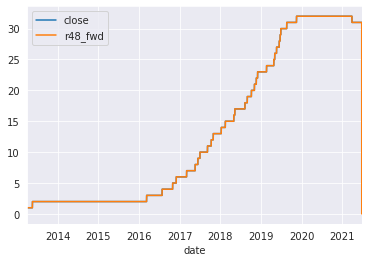

In [46]:
cols = ['close', f'r{t:02}_fwd']
prices[cols].groupby('date').count().plot()

## Remove outliers

In [47]:
prices[[f'r{t:02}' for t in T]].describe(percentiles=percentiles)

,r01,r02,r03,r04,r05,r06,r12,r24,r48
count,1.162691e+07,1.162688e+07,1.162684e+07,1.162681e+07,1.162678e+07,1.162675e+07,1.162656e+07,1.162617e+07,1.162540e+07
mean,4.222446e-05,6.415544e-05,8.565549e-05,1.063950e-04,1.245455e-04,1.426124e-04,2.443375e-04,4.252151e-04,7.637679e-04
std,3.886389e-02,3.938641e-02,4.020524e-02,3.998247e-02,4.027350e-02,4.071681e-02,4.324879e-02,4.590945e-02,5.951671e-02
min,-9.895060e-01,-9.899621e-01,-9.894000e-01,-9.894000e-01,-9.895060e-01,-9.894000e-01,-9.911667e-01,-9.918461e-01,-9.915571e-01
0.1%,-3.820970e-02,-5.440138e-02,-6.625490e-02,-7.598859e-02,-8.356031e-02,-9.077573e-02,-1.227573e-01,-1.604427e-01,-2.045887e-01
1%,-1.279080e-02,-1.835927e-02,-2.269746e-02,-2.638023e-02,-2.962734e-02,-3.251791e-02,-4.636103e-02,-6.429507e-02,-8.760897e-02
2%,-8.919537e-03,-1.294535e-02,-1.601172e-02,-1.863454e-02,-2.096906e-02,-2.307111e-02,-3.316581e-02,-4.698095e-02,-6.544922e-02
3%,-7.028878e-03,-1.028691e-02,-1.279299e-02,-1.493065e-02,-1.678950e-02,-1.850671e-02,-2.673185e-02,-3.828228e-02,-5.384332e-02
4%,-5.824251e-03,-8.618712e-03,-1.073968e-02,-1.256412e-02,-1.417415e-02,-1.560014e-02,-2.261316e-02,-3.256692e-02,-4.622298e-02
5%,-4.972100e-03,-7.416964e-03,-9.282529e-03,-1.086774e-02,-1.227784e-02,-1.354812e-02,-1.966673e-02,-2.846005e-02,-4.061633e-02


We remove daily returns above 100 percent as these are more likely to represent data errors; we are using the 100 percent cutoff here in a somewhat ad-hoc fashion; you would want to apply more careful exploratory and historical analysis to decide which assets are truly not representative of the sample period.

In [48]:
#outliers = prices[prices.r01 > 1].index.get_level_values(glevel).unique()

In [49]:
#prices = prices.drop(outliers, level=glevel)

## Create time and sector dummy variables

In [50]:
prices['year'] = prices.index.get_level_values('date').year.astype('int16')
prices['month'] = prices.index.get_level_values('date').month.astype('int16')
prices['weekday'] = prices.index.get_level_values('date').weekday.astype('int16')
prices['hour'] = prices.index.get_level_values('date').hour.astype('int16')

## Store Model Data

In [51]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11626940 entries, (Timestamp('2013-04-01 00:10:00', freq='5T'), 'btc-usd') to (Timestamp('2021-06-23 14:35:00', freq='5T'), 'chz-usd')
Data columns (total 53 columns):
 #   Column       Dtype  
---  ------       -----  
 0   open         float32
 1   high         float32
 2   low          float32
 3   close        float32
 4   volume       float64
 5   rsi          float64
 6   bb_high      float64
 7   bb_low       float64
 8   NATR         float64
 9   ATR          float64
 10  PPO          float64
 11  MACD         float64
 12  sector       int64  
 13  r01          float32
 14  r02          float32
 15  r03          float32
 16  r04          float32
 17  r05          float32
 18  r06          float32
 19  r12          float32
 20  r24          float32
 21  r48          float32
 22  r01dec       float64
 23  r02dec       float64
 24  r03dec       float64
 25  r04dec       float64
 26  r05dec       float64
 27  r06dec       float64
 2

In [52]:
prices.unstack(['ticker'])

open                                      \
ticker                    btc-usd     ltc-usd      eth-usd    etc-usd   
date                                                                    
2013-04-01 00:10:00     93.250000         NaN          NaN        NaN   
2013-04-01 00:15:00     93.349998         NaN          NaN        NaN   
2013-04-01 00:20:00     93.349998         NaN          NaN        NaN   
2013-04-01 00:25:00     93.349998         NaN          NaN        NaN   
2013-04-01 00:30:00     93.043991         NaN          NaN        NaN   
...                           ...         ...          ...        ...   
2021-06-23 14:15:00  33977.000000  128.479996  1987.680664  40.804001   
2021-06-23 14:20:00           NaN         NaN          NaN        NaN   
2021-06-23 14:25:00           NaN         NaN          NaN        NaN   
2021-06-23 14:30:00           NaN         NaN          NaN        NaN   
2021-06-23 14:35:00           NaN         NaN          NaN        NaN   

                                                                            \
ticker                  zec-usd     xmr-usd    dash-usd  xrp-usd miota-usd   
date                                                                         
2013-04-01 00:10:00         NaN         NaN         NaN      NaN       NaN   
2013-04-01 00:15:00         NaN         NaN         NaN      NaN       NaN   
2013-04-01 00:20:00         NaN         NaN         NaN      NaN       NaN   
2013-04-01 00:25:00         NaN         NaN         NaN      NaN       NaN   
2013-04-01 00:30:00         NaN         NaN         NaN      NaN       NaN   
...                         ...         ...         ...      ...       ...   
2021-06-23 14:15:00  112.309998  214.589996  126.769997  0.63476   0.79261   
2021-06-23 14:20:00         NaN  215.919998  127.320000  0.63990   0.79637   
2021-06-23 14:25:00         NaN         NaN         NaN      NaN       NaN   
2021-06-23 14:30:00         NaN         NaN         NaN      NaN       NaN   
2021-06-23 14:35:00         NaN         NaN         NaN      NaN       NaN   

                             ...    hour                                    \
ticker              eos-usd  ... bsv-usd btt-usd atom-usd wbtc-usd leo-usd   
date                         ...                                             
2013-04-01 00:10:00     NaN  ...     NaN     NaN      NaN      NaN     NaN   
2013-04-01 00:15:00     NaN  ...     NaN     NaN      NaN      NaN     NaN   
2013-04-01 00:20:00     NaN  ...     NaN     NaN      NaN      NaN     NaN   
2013-04-01 00:25:00     NaN  ...     NaN     NaN      NaN      NaN     NaN   
2013-04-01 00:30:00     NaN  ...     NaN     NaN      NaN      NaN     NaN   
...                     ...  ...     ...     ...      ...      ...     ...   
2021-06-23 14:15:00  3.6673  ...    14.0    14.0     14.0     14.0    14.0   
2021-06-23 14:20:00  3.6813  ...    14.0    14.0     14.0     14.0    14.0   
2021-06-23 14:25:00     NaN  ...    14.0    14.0     14.0     14.0    14.0   
2021-06-23 14:30:00     NaN  ...    14.0    14.0     14.0     14.0    14.0   
2021-06-23 14:35:00     NaN  ...     NaN     NaN      NaN      NaN    14.0   

                                                              
ticker              okb-usd algo-usd amp-usd ftt-usd chz-usd  
date                                                          
2013-04-01 00:10:00     NaN      NaN     NaN     NaN     NaN  
2013-04-01 00:15:00     NaN      NaN     NaN     NaN     NaN  
2013-04-01 00:20:00     NaN      NaN     NaN     NaN     NaN  
2013-04-01 00:25:00     NaN      NaN     NaN     NaN     NaN  
2013-04-01 00:30:00     NaN      NaN     NaN     NaN     NaN  
...                     ...      ...     ...     ...     ...  
2021-06-23 14:15:00     NaN     14.0    14.0     NaN    14.0  
2021-06-23 14:20:00     NaN     14.0    14.0     NaN    14.0  
2021-06-23 14:25:00     NaN     14.0    14.0     NaN    14.0  
2021-06-23 14:30:00     NaN     14.0    14.0     NaN    14.0  
2

In [53]:
prices_small = reduce_footprint(prices.dropna(), except_cols=['volume'])
inf = prices_small.index[np.isinf(prices_small).any(1)]
nan = prices_small.index[np.isnan(prices_small).any(1)]

inf, nan

(MultiIndex([], names=['date', 'ticker']),
 MultiIndex([], names=['date', 'ticker']))

In [54]:
prices_small.sort_index(inplace=True)
prices_small.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).reset_index().to_feather('data.feather' + suffix)
prices_small[['open', 'close', 'low', 'high', 'volume']].reset_index().to_feather('prices.feather' + suffix)
prices_small.reset_index().to_feather('data+prices.feather' + suffix)

prices_small.info(show_counts=True)



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11623852 entries, (Timestamp('2013-04-01 04:10:00', freq='5T'), 'btc-usd') to (Timestamp('2021-06-23 10:35:00', freq='5T'), 'leo-usd')
Data columns (total 53 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         11623852 non-null  float32
 1   high         11623852 non-null  float32
 2   low          11623852 non-null  float32
 3   close        11623852 non-null  float32
 4   volume       11623852 non-null  float64
 5   rsi          11623852 non-null  float32
 6   bb_high      11623852 non-null  float32
 7   bb_low       11623852 non-null  float32
 8   NATR         11623852 non-null  float32
 9   ATR          11623852 non-null  float32
 10  PPO          11623852 non-null  float32
 11  MACD         11623852 non-null  float32
 12  sector       11623852 non-null  int16  
 13  r01          11623852 non-null  float32
 14  r02          11623852 non-null  float32
 15  r03         